In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip -q "/content/drive/MyDrive/0208.zip" -d "/content/ds000208"

In [ ]:
!unzip -q "/content/drive/MyDrive/140.zip" -d "/content/ds000140"

#Old Code Block

In [ ]:
!pip install nilearn nibabel scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 99.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipython-input-5-2404131901.py:8: UserWarning: Casting data from int32 to float32
  view = plotting.view_img(img_3d, threshold=None)



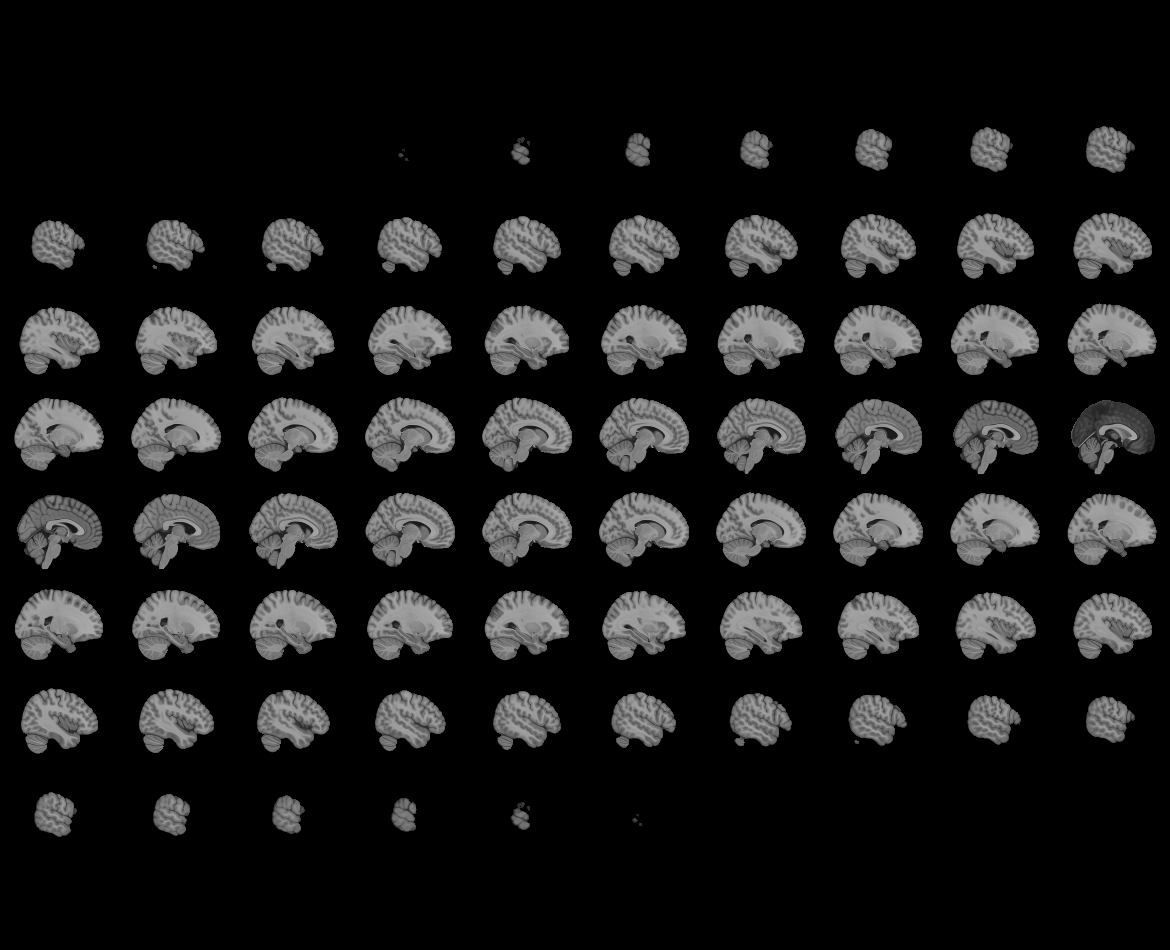
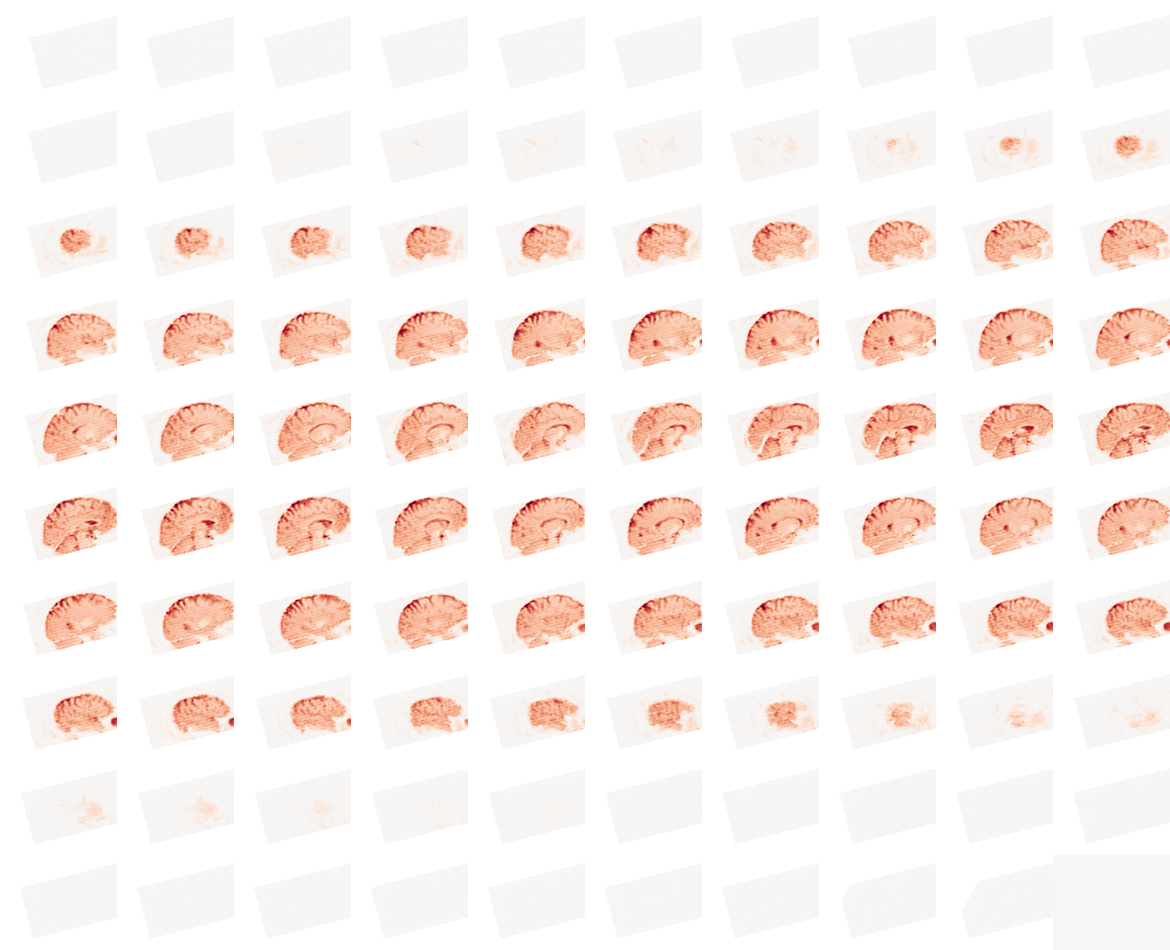

In [ ]:
from nilearn import plotting

example_file = "/content/ds000208/0208/sub-01/func/sub-01_task-rest_bold.nii.gz"

from nilearn.image import index_img
img_3d = index_img(example_file, 0)

view = plotting.view_img(img_3d, threshold=None)
view

In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
Device name: Tesla T4


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = atlas.maps
labels = atlas.labels
print(f"Atlas loaded: {len(labels)} ROIs")

def extract_roi_features_mean(dataset_root, label):
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
    features, labels_out = [], []

    for subj in sorted(os.listdir(dataset_root)):
        func_path = os.path.join(dataset_root, subj, "func")
        if not os.path.isdir(func_path):
            continue

        for file in os.listdir(func_path):
            if file.endswith(".nii.gz"):
                try:
                    img_path = os.path.join(func_path, file)
                    data = masker.fit_transform(img_path)
                    roi_means = data.mean(axis=0)
                    features.append(roi_means)
                    labels_out.append(label)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")

    return features, labels_out

X_pain, y_pain = extract_roi_features_mean("/content/ds000208/0208", label=1)
X_ctrl, y_ctrl = extract_roi_features_mean("/content/ds000140/140", label=0)

[fetch_atlas_harvard_oxford] Dataset found in /root/nilearn_data/fsl

Atlas loaded: 49 ROIs


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py:319: UserWarning: After resampling the label image to the data image, the following labels were removed: {np.uint8(48)}. Label image only contains 48 labels (including background).
  data_to_wrap = f(self, X, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py:319: UserWarning: After resampling the label image to the data image, the following labels were removed: {np.uint8(32), np.uint8(37), np.uint8(40), np.uint8(14), np.uint8(47), np.uint8(48), np.uint8(23), np.uint8(24)}. Label image only contains 41 labels (including background).
  data_to_wrap = f(self, X, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py:319: UserWarning: After resampling the label image to the data image, the following labels were removed: {np.uint8(32), np.uint8(37), np.uint8(40), np.uint8(14), np.uint8(47), np.uint8(48), np.uint8(23), np.uint8(24), np.uint8(25)}. Label imag

In [ ]:
expected_dim = len(X_pain[0]) if X_pain else 0
X_all, y_all = [], []

for x, y_val in zip(X_pain + X_ctrl, y_pain + y_ctrl):
    if len(x) == expected_dim:
        X_all.append(x)
        y_all.append(y_val)
    else:
        print(f"Skipping vector of length {len(x)} (expected {expected_dim})")

X = np.array(X_all)
y = np.array(y_all)

print(f"Cleaned shape: {X.shape}, Label counts: {np.bincount(y)}")

Skipping vector of length 47 (expected 48)
Skipping vector of length 40 (expected 48)
Skipping vector of length 39 (expected 48)
Skipping vector of length 46 (expected 48)
Skipping vector of length 42 (expected 48)
Skipping vector of length 44 (expected 48)
Skipping vector of length 32 (expected 48)
Skipping vector of length 46 (expected 48)
Skipping vector of length 47 (expected 48)
Skipping vector of length 42 (expected 48)
Skipping vector of length 43 (expected 48)
Skipping vector of length 39 (expected 48)
Skipping vector of length 40 (expected 48)
Skipping vector of length 42 (expected 48)
Skipping vector of length 40 (expected 48)
Skipping vector of length 46 (expected 48)
Skipping vector of length 45 (expected 48)
Skipping vector of length 44 (expected 48)
Skipping vector of length 44 (expected 48)
Skipping vector of length 45 (expected 48)
Skipping vector of length 45 (expected 48)
Skipping vector of length 45 (expected 48)
Skipping vector of length 44 (expected 48)
Skipping ve

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))


Train label distribution: [107   1]
Test label distribution: [46  1]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca = pca.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train_bal)

y_pred = clf.predict(X_test_pca)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00         1

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



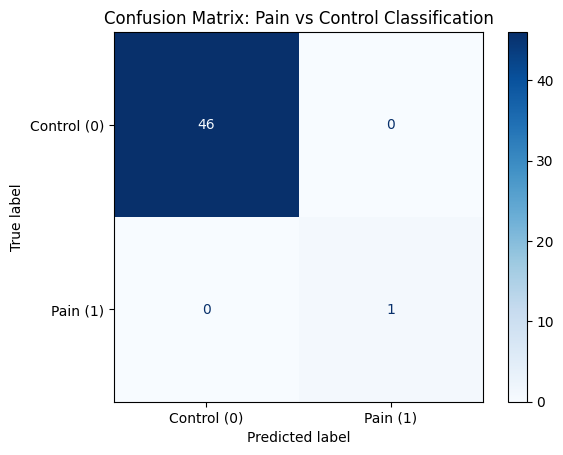

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control (0)', 'Pain (1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Pain vs Control Classification")
plt.grid(False)
plt.show()

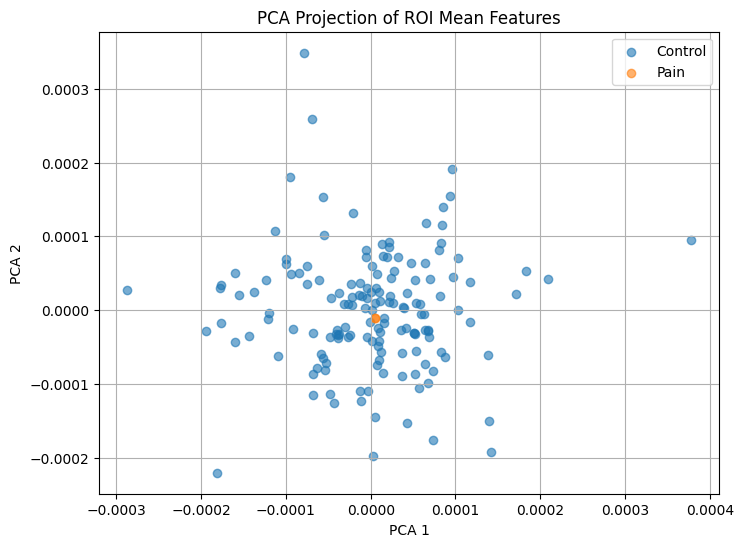

In [ ]:
X_pca_all = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_all[y == 0, 0], X_pca_all[y == 0, 1], label='Control', alpha=0.6)
plt.scatter(X_pca_all[y == 1, 0], X_pca_all[y == 1, 1], label='Pain', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Projection of ROI Mean Features')
plt.legend()
plt.grid(True)
plt.show()

#New Code Block

In [ ]:
!pip install shap lime seaborn scikit-learn matplotlib pandas nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 63.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d650582e7f3fc2de3e48388d9ca8168253955450dae678b14c98e4d03dbd5d5b
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, image
from nilearn.input_data import NiftiLabelsMasker

# === Settings ===
base_dir = "/content"
dataset_dirs = {
    "ds000208/0208": 1,  # Label 1: Pain
    "ds000140/140": 0    # Label 0: Control
}
output_csv = "mvpa_combined_features.csv"

# === Load AAL Atlas ===
print("Loading AAL atlas...")
aal = datasets.fetch_atlas_aal()
atlas_img = nib.load(aal.maps)
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True)

# === Extraction ===
features, subject_ids, labels = [], [], []

for dataset_relpath, label in dataset_dirs.items():
    dataset_path = os.path.join(base_dir, dataset_relpath)
    if not os.path.isdir(dataset_path):
        print(f"Dataset folder missing: {dataset_path}")
        continue

    for subj in sorted(os.listdir(dataset_path)):
        func_path = os.path.join(dataset_path, subj, "func")
        if not os.path.isdir(func_path):
            continue

        for file in os.listdir(func_path):
            if file.endswith(".nii.gz") and "task" in file:
                filepath = os.path.join(func_path, file)
                print(f"Processing: {filepath}")
                try:
                    subj_img = nib.load(filepath)
                    resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
                    ts = masker.fit_transform(resampled_img)
                    if ts.shape[0] == 0:
                        raise ValueError("Empty time series.")
                    avg_signal = np.mean(ts, axis=0)
                    features.append(avg_signal)
                    subject_ids.append(f"{dataset_relpath.replace('/', '_')}_{subj}")
                    labels.append(label)
                except Exception as e:
                    print(f"Skipping {filepath}: {e}")

# === Save to CSV ===
if features:
    n_features = len(features[0])
    df = pd.DataFrame(features, index=subject_ids, columns=aal.labels[:n_features])
    df["Label"] = labels
    df.index.name = "Subject_ID"
    df.to_csv(output_csv)
    print(f"\nSaved extracted features to '{output_csv}' with shape: {df.shape}")
else:
    print("No features extracted. Check your .nii.gz files or preprocessing.")

/tmp/ipython-input-5-792663723.py:6: DeprecationWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  from nilearn.input_data import NiftiLabelsMasker


Loading AAL atlas...


/tmp/ipython-input-5-792663723.py:18: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal()


[fetch_atlas_aal] Added README.md to /root/nilearn_data

[fetch_atlas_aal] Dataset created in /root/nilearn_data/aal_SPM12

[fetch_atlas_aal] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_atlas_aal]  ...done. (2 seconds, 0 min)

[fetch_atlas_aal] Extracting data from 
/root/nilearn_data/aal_SPM12/5d72fe1c9daf02b658cbf1f7e7026e0f/aal_for_SPM12.tar.gz...

[fetch_atlas_aal] .. done.

Processing: /content/ds000208/0208/sub-01/func/sub-01_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-02/func/sub-02_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-03/func/sub-03_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-04/func/sub-04_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-05/func/sub-05_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-06/func/sub-06_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-07/func/sub-07_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-08/func/sub-08_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-09/func/sub-09_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-10/func/sub-10_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-11/func/sub-11_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-12/func/sub-12_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-13/func/sub-13_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-14/func/sub-14_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-15/func/sub-15_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-16/func/sub-16_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-17/func/sub-17_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-18/func/sub-18_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-19/func/sub-19_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-20/func/sub-20_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-21/func/sub-21_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-22/func/sub-22_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-23/func/sub-23_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-24/func/sub-24_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-25/func/sub-25_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-26/func/sub-26_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-27/func/sub-27_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-28/func/sub-28_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-29/func/sub-29_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-30/func/sub-30_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-31/func/sub-31_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-32/func/sub-32_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-33/func/sub-33_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-34/func/sub-34_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-35/func/sub-35_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-36/func/sub-36_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-37/func/sub-37_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-38/func/sub-38_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-39/func/sub-39_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000208/0208/sub-40/func/sub-40_task-rest_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: UserWarning: Casting data from int16 to float32
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-01/func/sub-01_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-02/func/sub-02_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-03/func/sub-03_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-04/func/sub-04_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-05/func/sub-05_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-06/func/sub-06_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-07/func/sub-07_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-08/func/sub-08_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-09/func/sub-09_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-10/func/sub-10_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-11/func/sub-11_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-12/func/sub-12_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-13/func/sub-13_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-14/func/sub-14_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-15/func/sub-15_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-16/func/sub-16_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-09_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-03_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-02_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-01_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-07_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-06_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-08_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-04_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")


Processing: /content/ds000140/140/sub-17/func/sub-17_task-heatpainwithregulationandratings_run-05_bold.nii.gz


/tmp/ipython-input-5-792663723.py:42: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")
/tmp/ipython-input-5-792663723.py:42: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled_img = image.resample_to_img(subj_img, atlas_img, interpolation="continuous")



Saved extracted features to 'mvpa_combined_features.csv' with shape: (193, 117)


In [ ]:
!pip install shap lime scikit-learn matplotlib seaborn

Loaded: 193 subjects, 116 features + labels

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.52      0.67        31
           1       0.32      0.88      0.47         8

    accuracy                           0.59        39
   macro avg       0.63      0.70      0.57        39
weighted avg       0.81      0.59      0.63        39



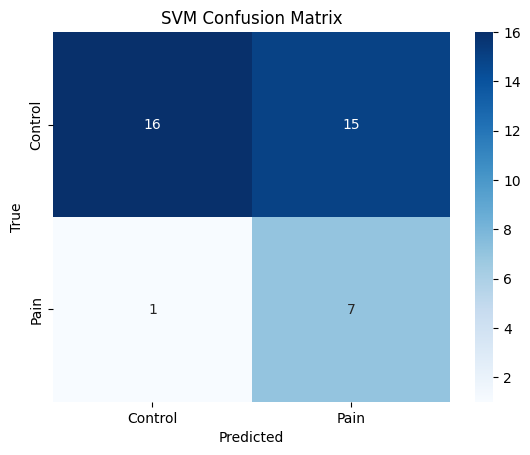


LDA Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.39      0.52        31
           1       0.21      0.62      0.31         8

    accuracy                           0.44        39
   macro avg       0.50      0.51      0.42        39
weighted avg       0.68      0.44      0.48        39



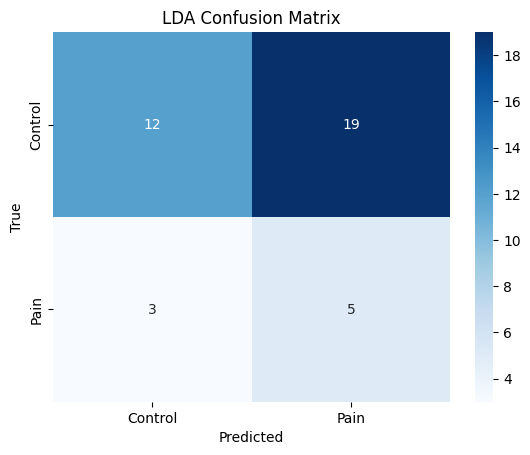


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       1.00      0.75      0.86         8

    accuracy                           0.95        39
   macro avg       0.97      0.88      0.91        39
weighted avg       0.95      0.95      0.95        39



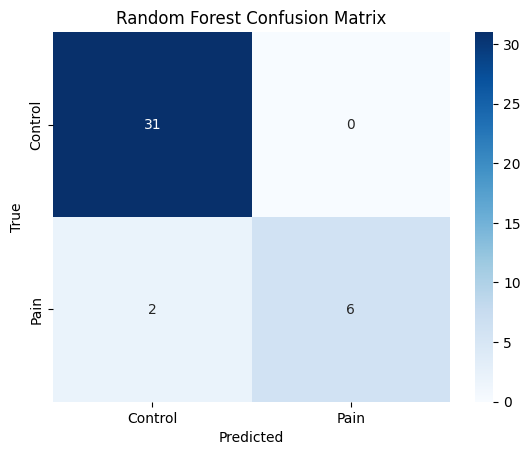


Best SVM Params: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Best CV F1 Score: 0.9302236465480641


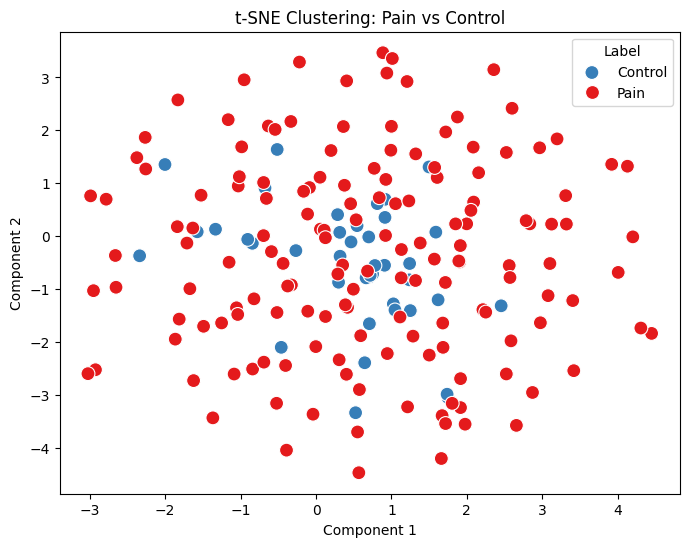

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer

# ==== Load CSV ====
df = pd.read_csv("/content/mvpa_combined_features.csv", index_col=0).dropna()
print(f"Loaded: {df.shape[0]} subjects, {df.shape[1]-1} features + labels")

# ==== Features & Labels ====
X = df.drop(columns=["Label"]).values
y = df["Label"].values
region_names = df.columns[:-1]

# ==== Standardize ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==== Dimensionality Reduction ====
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
X_tsne = tsne.fit_transform(X_scaled)

# ==== Train/Test Split ====
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ==== Train Models ====
svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
lda = LinearDiscriminantAnalysis()
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

svm.fit(X_train, y_train)
lda.fit(X_train, y_train)
rf.fit(X_train, y_train)

# ==== Evaluation ====
def evaluate(name, model, X_eval, y_eval):
    print(f"\n{name} Classification Report:\n", classification_report(y_eval, model.predict(X_eval)))
    cm = confusion_matrix(y_eval, model.predict(X_eval))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Control", "Pain"], yticklabels=["Control", "Pain"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate("SVM", svm, X_test, y_test)
evaluate("LDA", lda, X_test, y_test)
evaluate("Random Forest", rf, X_test, y_test)

# ==== Grid Search for SVM (Optional Fine-Tuning) ====
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_scaled, y)
print("\nBest SVM Params:", grid.best_params_)
print("Best CV F1 Score:", grid.best_score_)

# ==== LIME on Raw ROI Features ====
lime_explainer = LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=region_names,
    class_names=["Control", "Pain"],
    mode="classification"
)
lime_exp = lime_explainer.explain_instance(X_scaled[0], rf.predict_proba, num_features=10)
lime_exp.show_in_notebook()

# ==== t-SNE Clustering Plot ====
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="Set1", s=100)
plt.title("t-SNE Clustering: Pain vs Control")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", labels=["Control", "Pain"])
plt.show()

In [ ]:
pip install nilearn nibabel

In [ ]:
import numpy as np

shap_mean = np.abs(shap_values.values).mean(axis=0)

top_k = 30
top_indices = np.argsort(shap_mean)[-top_k:][::-1]

top_regions = region_names[top_indices].tolist()

print("Top SHAP Brain Regions:")
for i, region in enumerate(top_regions, 1):
    print(f"{i}. {region}")

Top SHAP Brain Regions:
1. Cuneus_L
2. Cerebelum_3_R
3. Cerebelum_Crus1_L
4. Insula_L
5. Cerebelum_6_L
6. Vermis_8
7. Supp_Motor_Area_R
8. Frontal_Sup_L
9. Caudate_R
10. Caudate_L
11. Putamen_R
12. Cingulum_Post_R
13. Calcarine_R
14. Cerebelum_10_L
15. Cuneus_R
16. Rolandic_Oper_R
17. Vermis_7
18. Hippocampus_L
19. Occipital_Mid_L
20. Temporal_Pole_Sup_R
21. Occipital_Sup_R
22. Occipital_Sup_L
23. Cingulum_Ant_R
24. Fusiform_L
25. Cingulum_Post_L
26. Angular_R
27. Rectus_R
28. Cerebelum_9_L
29. Vermis_3
30. Precentral_R


/tmp/ipython-input-24-2126542155.py:16: DeprecationWarning: Starting in version 0.13, the default fetched mask will beAAL 3v2 instead.
  aal = datasets.fetch_atlas_aal(version='SPM12')


[fetch_atlas_aal] Dataset found in /root/nilearn_data/aal_SPM12

Top SHAP Regions: [('Cuneus_L', np.float64(1.0368863206155343)), ('Cerebellum_3_R', np.float64(0.7955581376296799)), ('Cerebellum_Crus1_L', np.float64(0.7786030186393367)), ('Insula_L', np.float64(0.7316552483053533)), ('Cerebellum_6_L', np.float64(0.6850571714346237)), ('Vermis_8', np.float64(0.6517202656492843)), ('Supp_Motor_Area_R', np.float64(0.6482284442092506)), ('Frontal_Sup_L', np.float64(0.5999797541302171)), ('Caudate_R', np.float64(0.5819928585231836)), ('Caudate_L', np.float64(0.5755980583170934))]
Region not found: Cerebellum_3_R
Region not found: Cerebellum_Crus1_L
Region not found: Cerebellum_6_L


/tmp/ipython-input-24-2126542155.py:55: UserWarning: empty mask
  plotting.plot_stat_map(


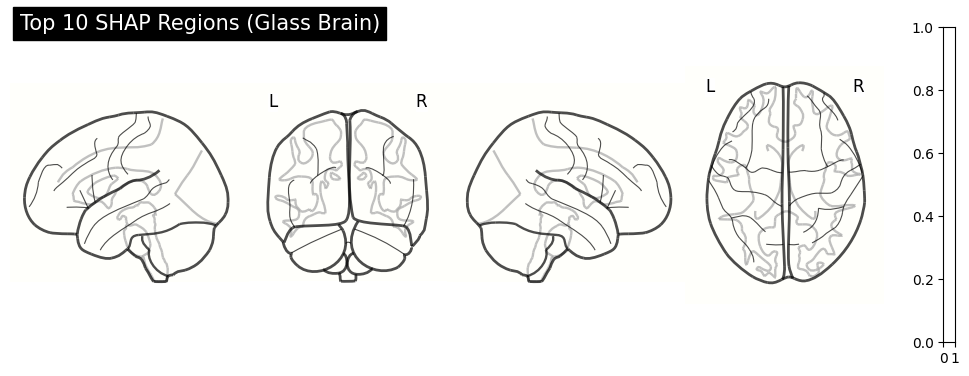

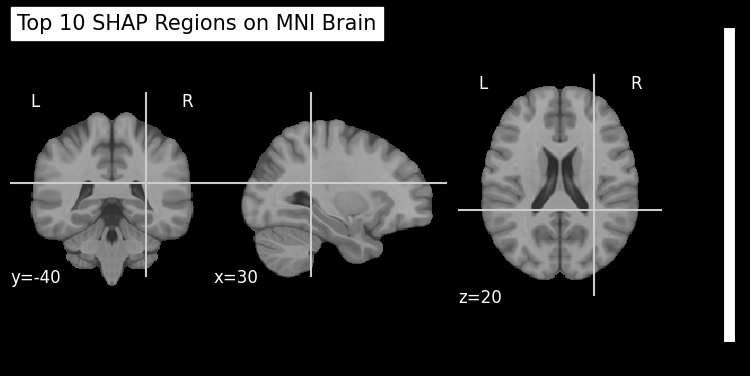

In [ ]:
from nilearn import plotting, datasets
from nilearn.datasets import load_mni152_template
import nibabel as nib
import numpy as np

from nilearn import plotting, datasets, image
import nibabel as nib
import numpy as np

# === CONFIGURATION ===
TOP_N = 10
shap_matrix = np.abs(shap_values.values).mean(axis=0)
region_shap = dict(zip(region_names, shap_matrix))

# === LOAD AAL ATLAS ===
aal = datasets.fetch_atlas_aal(version='SPM12')
atlas_img = nib.load(aal.maps)
atlas_data = atlas_img.get_fdata()
atlas_labels = aal.labels
label_to_index = {label: idx + 1 for idx, label in enumerate(atlas_labels)}

# === HANDLE LABEL NAME DISCREPANCY ===
def clean(name):
    return name.replace("Cerebelum", "Cerebellum")

region_shap_cleaned = {clean(k): v for k, v in region_shap.items()}

# === SELECT TOP-N SHAP REGIONS ===
sorted_regions = sorted(region_shap_cleaned.items(), key=lambda x: x[1], reverse=True)
top_regions = sorted_regions[:TOP_N]
print("Top SHAP Regions:", top_regions)

# === CREATE MASK ===
stat_map = np.zeros_like(atlas_data)

for region, score in top_regions:
    idx = label_to_index.get(region)
    if idx is None:
        print(f"Region not found: {region}")
        continue
    stat_map[atlas_data == idx] = score  # Use actual SHAP value

stat_img = nib.Nifti1Image(stat_map, affine=atlas_img.affine)
template = load_mni152_template()

# === PLOT 1: GLASS BRAIN ===
plotting.plot_glass_brain(
    stat_img,
    display_mode='lyrz',
    colorbar=True,
    title=f"Top {TOP_N} SHAP Regions (Glass Brain)"
)

# === PLOT 2: OVERLAY ON TEMPLATE ===
plotting.plot_stat_map(
    stat_img,
    bg_img=template,
    display_mode='ortho',
    threshold=0.1,
    cut_coords=(30, -40, 20),
    cmap='hot',
    title=f"Top {TOP_N} SHAP Regions on MNI Brain",
    colorbar=True
)

plotting.show()